# 1) Se cargan las librerias necesarias

In [26]:
# Librerías estándar y manipulación de archivos
import os
import joblib
import json
import pickle

# Manipulación de datos y operaciones básicas
import numpy as np
import pandas as pd

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento de datos
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Reducción de dimensionalidad
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Modelos de Machine Learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Selección y validación de modelos
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV

# Técnicas de balanceo de clases
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Métricas de evaluación
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc

# Configuraciones adicionales
import warnings

# Se ignoran los warnings en el notebook
warnings.filterwarnings('ignore')



# 2) Carga y visualización de la base de datos

In [27]:
medical_appointments = pd.read_csv('Attendance of Medical Appointments in Brazil (may2016).csv')
# Numero de filas y columnas
medical_appointments.shape

(110527, 14)

In [28]:
# Información de las columnas
medical_appointments.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [29]:
# Numero de valores unicos por columna
column_counts = medical_appointments.nunique()
print(column_counts)

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64


In [30]:
# Evaluar presencia de Missing values
missing_values = medical_appointments.isnull().sum()
print(missing_values)

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64


In [31]:
# Tipo de datos
data_types = medical_appointments.dtypes
print(data_types)

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object


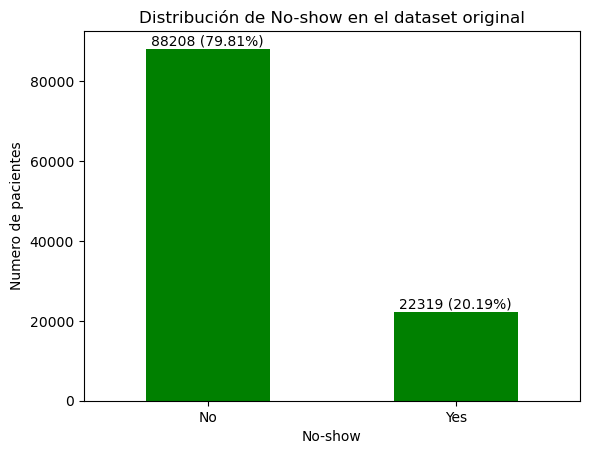

In [32]:
# Distribución del dataset original
class_counts = medical_appointments['No-show'].value_counts()
class_counts.plot(kind='bar', rot=0, color=['green'])
plt.xlabel('No-show')
plt.ylabel('Numero de pacientes')
plt.title('Distribución de No-show en el dataset original')
for i, count in enumerate(class_counts):
    plt.text(i, count, f'{count} ({count / len(medical_appointments) * 100:.2f}%)', ha='center', va='bottom')
plt.show()

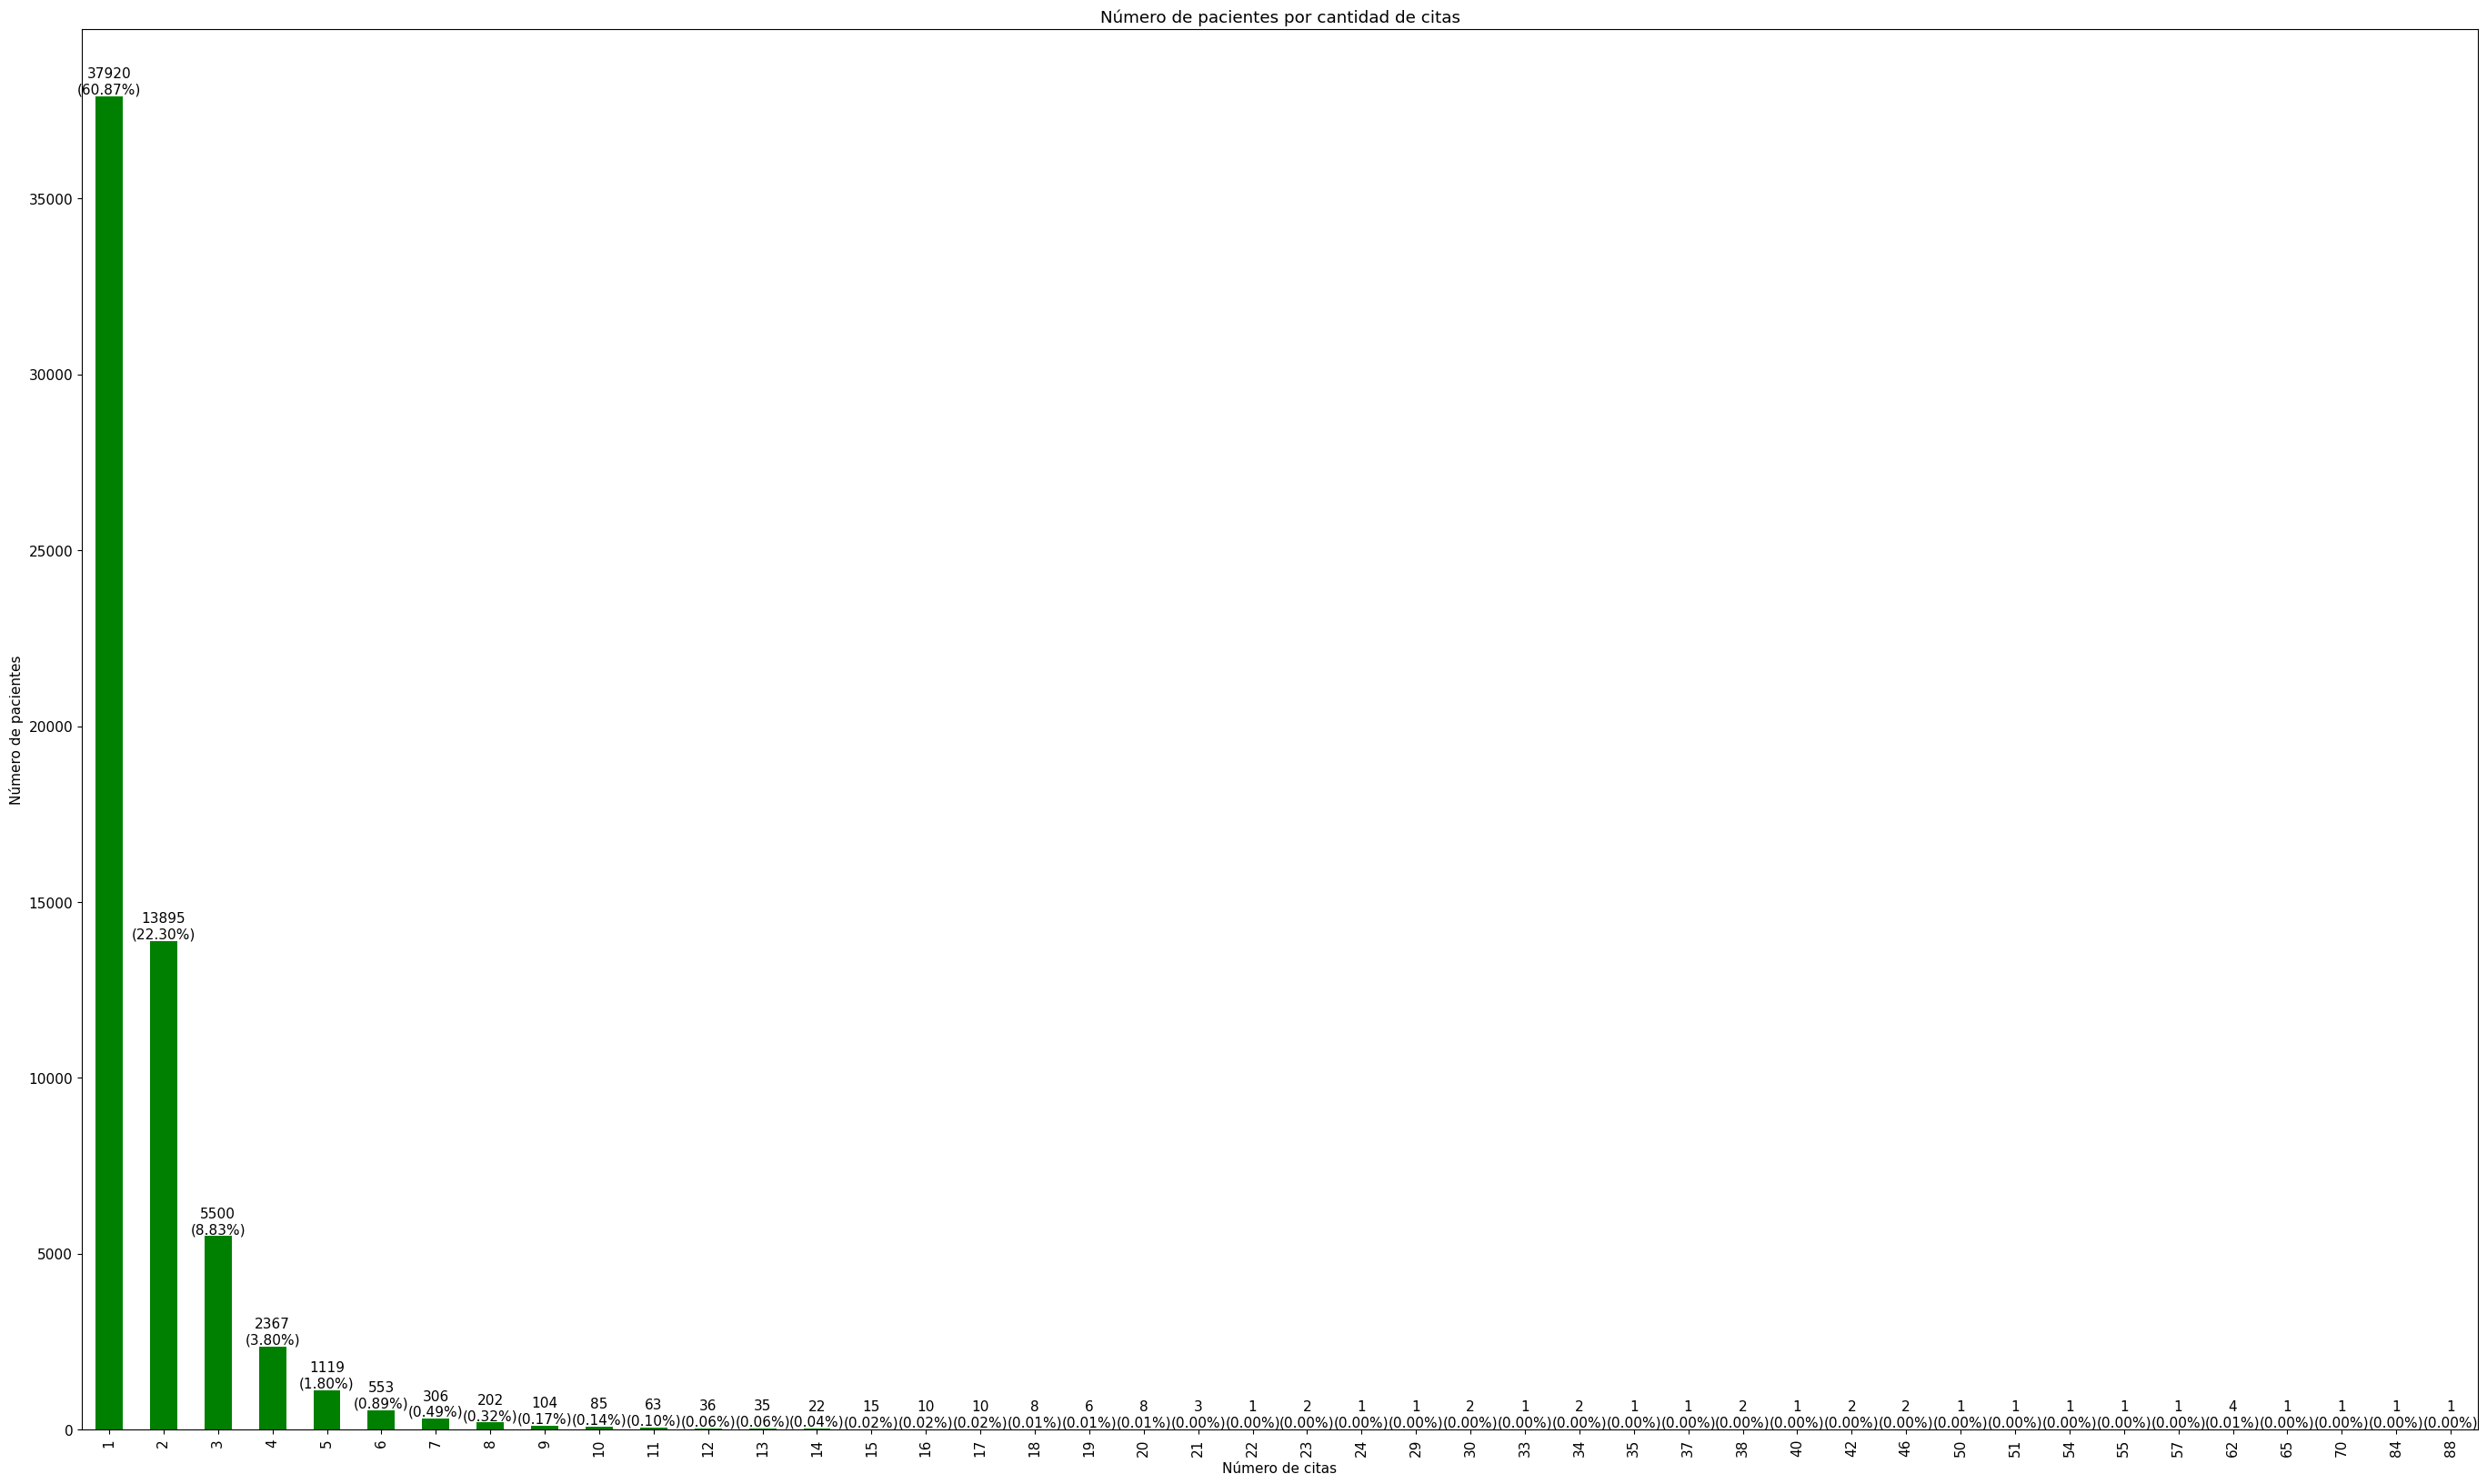

In [33]:
# Numero de citas por paciente
appointment_counts = medical_appointments['PatientId'].value_counts()

# Crear una serie que cuente cuántos pacientes tienen X número de citas
appointment_counts_summary = appointment_counts.value_counts().sort_index()

# Se modifica el tamaño de la figura
plt.figure(figsize=(34,20))

# Se modifica el tamaño de la fuente
plt.rcParams.update({'font.size': 11})

# Graficar la distribución
appointment_counts_summary.plot(kind='bar', color='green')
plt.xlabel('Número de citas')
plt.ylabel('Número de pacientes')
plt.title('Número de pacientes por cantidad de citas')

# Agregar texto sobre cada barra para mostrar el conteo y el porcentaje
for i, count in enumerate(appointment_counts_summary):
    percentage = count / len(appointment_counts) * 100
    plt.text(i, count, f'{count}\n({percentage:.2f}%)', ha='center', va='bottom')

# Muestra el gráfico
plt.show()


# 3) Feature Engeniering

In [34]:
# Se crea una copia del dataset original
medical_appointments_transformed = medical_appointments.copy()

# Transformar las fechas a formato datetime
medical_appointments_transformed['ScheduledDay'] = pd.to_datetime(medical_appointments_transformed['ScheduledDay'])
medical_appointments_transformed['AppointmentDay'] = pd.to_datetime(medical_appointments_transformed['AppointmentDay'])

# Se ordena el dataframe por el id del paciente y la fecha de la cita
medical_appointments_transformed.sort_values(by=['PatientId', 'ScheduledDay'], inplace=True)

# Se calcula el tiempo en segundos entre la fecha de la cita y la fecha de programación
medical_appointments_transformed['Time_Before_Appointment'] = (medical_appointments_transformed['AppointmentDay'] - medical_appointments_transformed['ScheduledDay']).dt.total_seconds()

# Se agrega el día de la semana de la cita
medical_appointments_transformed['Appointment_DayOfWeek'] = medical_appointments_transformed['AppointmentDay'].dt.day_name()

# Se calcula el tiempo en días desde la última cita de cada paciente
medical_appointments_transformed['Days Since Last Appointment'] = medical_appointments_transformed.groupby('PatientId')['ScheduledDay'].diff().dt.days

# Se asgina 0 a los pacientes que no tienen citas previas
medical_appointments_transformed['Days Since Last Appointment'].fillna(0, inplace=True)

# Se convierte de time a int
medical_appointments_transformed['ScheduledDay'] = medical_appointments_transformed['ScheduledDay'].dt.strftime('%Y%m%d').astype(int)
medical_appointments_transformed['AppointmentDay'] = medical_appointments_transformed['AppointmentDay'].dt.strftime('%Y%m%d').astype(int)

# Instanciar un nuevo LabelEncoder para cada columna categórica

gender_encoder = LabelEncoder()
neighbourhood_encoder = LabelEncoder()
no_show_encoder = LabelEncoder()
Appointment_DayOfWeek_encoder = LabelEncoder()

# Convertir las columnas categóricas a numéricas usando fit_transform
medical_appointments_transformed['Gender'] = gender_encoder.fit_transform(medical_appointments_transformed['Gender'])
medical_appointments_transformed['Neighbourhood'] = neighbourhood_encoder.fit_transform(medical_appointments_transformed['Neighbourhood'])
medical_appointments_transformed['No-show'] = no_show_encoder.fit_transform(medical_appointments_transformed['No-show'])
medical_appointments_transformed['Appointment_DayOfWeek'] = Appointment_DayOfWeek_encoder.fit_transform(medical_appointments_transformed['Appointment_DayOfWeek'])

# Visualizar los cambios
medical_appointments_transformed.head(10)



,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Time_Before_Appointment,Appointment_DayOfWeek,Days Since Last Appointment
100517,3.921784e+04,5751990,0,20160531,20160603,44,56,0,0,0,0,0,0,0,219799.0,0,0.0
105430,4.374176e+04,5760144,1,20160601,20160601,39,43,0,0,1,0,0,0,0,-51778.0,5,0.0
3950,9.377953e+04,5712759,0,20160518,20160518,33,10,0,0,0,0,0,0,0,-33149.0,5,0.0
73303,1.417242e+05,5637648,1,20160429,20160502,12,23,0,0,0,0,0,0,0,233184.0,1,0.0
73228,5.376153e+05,5637728,0,20160429,20160506,14,23,0,0,0,0,0,1,0,578403.0,0,0.0
54611,5.628261e+06,5680449,1,20160510,20160513,13,52,0,0,0,0,0,0,1,216102.0,0,0.0
40692,1.183186e+07,5718578,1,20160519,20160519,16,69,0,0,0,0,0,0,0,-34927.0,3,0.0
58616,2.263866e+07,5580835,0,20160414,20160503,22,35,0,0,0,0,0,1,0,1614990.0,4,0.0
88585,2.263866e+07,5715081,0,20160518,20160608,23,35,0,0,0,0,0,1,0,1765368.0,5,34.0
49826,5.216894e+07,5607220,0,20160420,20160517,28,39,0,0,0,0,0,0,0,2291865.0,4,0.0


In [35]:
#Se verifican los tipos de datos resultantes
data_types = medical_appointments_transformed.dtypes
print(data_types)

PatientId                      float64
AppointmentID                    int64
Gender                           int32
ScheduledDay                     int32
AppointmentDay                   int32
Age                              int64
Neighbourhood                    int32
Scholarship                      int64
Hipertension                     int64
Diabetes                         int64
Alcoholism                       int64
Handcap                          int64
SMS_received                     int64
No-show                          int32
Time_Before_Appointment        float64
Appointment_DayOfWeek            int32
Days Since Last Appointment    float64
dtype: object


# 3.1) Se divide el dataset en conjunto de entrenamiento y prueba
Para continuar el procesamiento

In [36]:
# Se divide el dataframe en conjuntos de entrenamiento y prueba de forma estratificada
test_idxs = medical_appointments_transformed.groupby('No-show').apply(lambda x: x.sample(frac=0.2, random_state=0)).index.get_level_values(1)

# Paso 2: Crear el conjunto de prueba utilizando los índices obtenidos
test_df = medical_appointments_transformed.loc[test_idxs]

# Paso 3: Crear el conjunto de entrenamiento excluyendo los índices del conjunto de prueba
train_df = medical_appointments_transformed.drop(test_idxs)


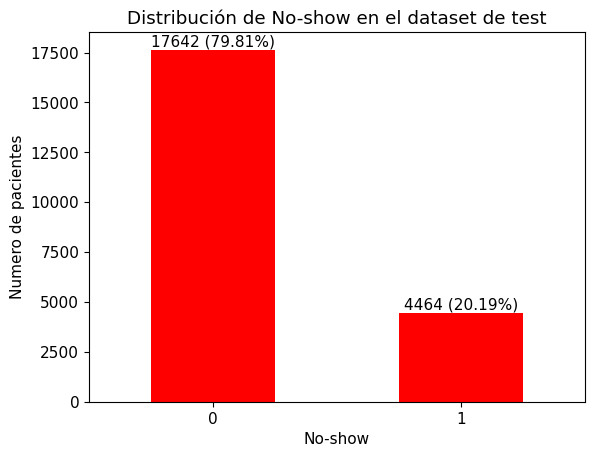

In [37]:
# Se verifican los conjunto de test resultante
class_counts_test = test_df['No-show'].value_counts()
class_counts_test.plot(kind='bar', rot=0, color='red')
plt.xlabel('No-show')
plt.ylabel('Numero de pacientes')
plt.title('Distribución de No-show en el dataset de test')
for i, count in enumerate(class_counts_test):
    plt.text(i, count, f'{count} ({count / len(test_df) * 100:.2f}%)', ha='center', va='bottom')

# 3.2) Feature Engeniering parte 2: 
Se generan variables del dataset de entrenamiento: porcentaje de inasistencias de pacientes a sus citas, para no contaminar los datos de test, que son datos futuros y no contamos con esa información

In [38]:
# Calcular la suma acumulativa de inasistencias ('No-show' == 1) por PatientId
train_df['Cumulative No-shows'] = train_df.groupby('PatientId')['No-show'].transform('cumsum')

# Calcular el número acumulativo de citas por PatientId 
train_df['Cumulative Appointments'] = train_df.groupby('PatientId').cumcount() + 1

# Calcular la probabilidad acumulativa de inasistencia por cita
train_df['Cumulative No-show Probability'] = train_df['Cumulative No-shows'] / train_df['Cumulative Appointments']

# Asignar un valor de 0 a la primera cita de cada paciente utilizando transform para mantener el índice
train_df['Cumulative No-show Probability'] = train_df.groupby('PatientId')['Cumulative No-show Probability'].transform(lambda x: x.shift().fillna(0))

# Se elioina la columna 'Cumulative No-shows'
train_df.drop(columns=['Cumulative No-shows'], inplace=True)

# Se observan los cambios
train_df.head(10)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Time_Before_Appointment,Appointment_DayOfWeek,Days Since Last Appointment,Cumulative Appointments,Cumulative No-show Probability
100517,3.921784e+04,5751990,0,20160531,20160603,44,56,0,0,0,0,0,0,0,219799.0,0,0.0,1,0.0
105430,4.374176e+04,5760144,1,20160601,20160601,39,43,0,0,1,0,0,0,0,-51778.0,5,0.0,1,0.0
3950,9.377953e+04,5712759,0,20160518,20160518,33,10,0,0,0,0,0,0,0,-33149.0,5,0.0,1,0.0
73228,5.376153e+05,5637728,0,20160429,20160506,14,23,0,0,0,0,0,1,0,578403.0,0,0.0,1,0.0
54611,5.628261e+06,5680449,1,20160510,20160513,13,52,0,0,0,0,0,0,1,216102.0,0,0.0,1,0.0
40692,1.183186e+07,5718578,1,20160519,20160519,16,69,0,0,0,0,0,0,0,-34927.0,3,0.0,1,0.0
58616,2.263866e+07,5580835,0,20160414,20160503,22,35,0,0,0,0,0,1,0,1614990.0,4,0.0,1,0.0
88585,2.263866e+07,5715081,0,20160518,20160608,23,35,0,0,0,0,0,1,0,1765368.0,5,34.0,2,0.0
83628,5.216894e+07,5704816,0,20160516,20160516,28,39,0,0,0,0,0,0,0,-60139.0,1,26.0,1,0.0
46340,5.422400e+07,5613714,1,20160425,20160511,32,36,0,0,0,0,0,1,0,1347822.0,5,0.0,1,0.0


# 3.3) Se visualiza la correlación de datos

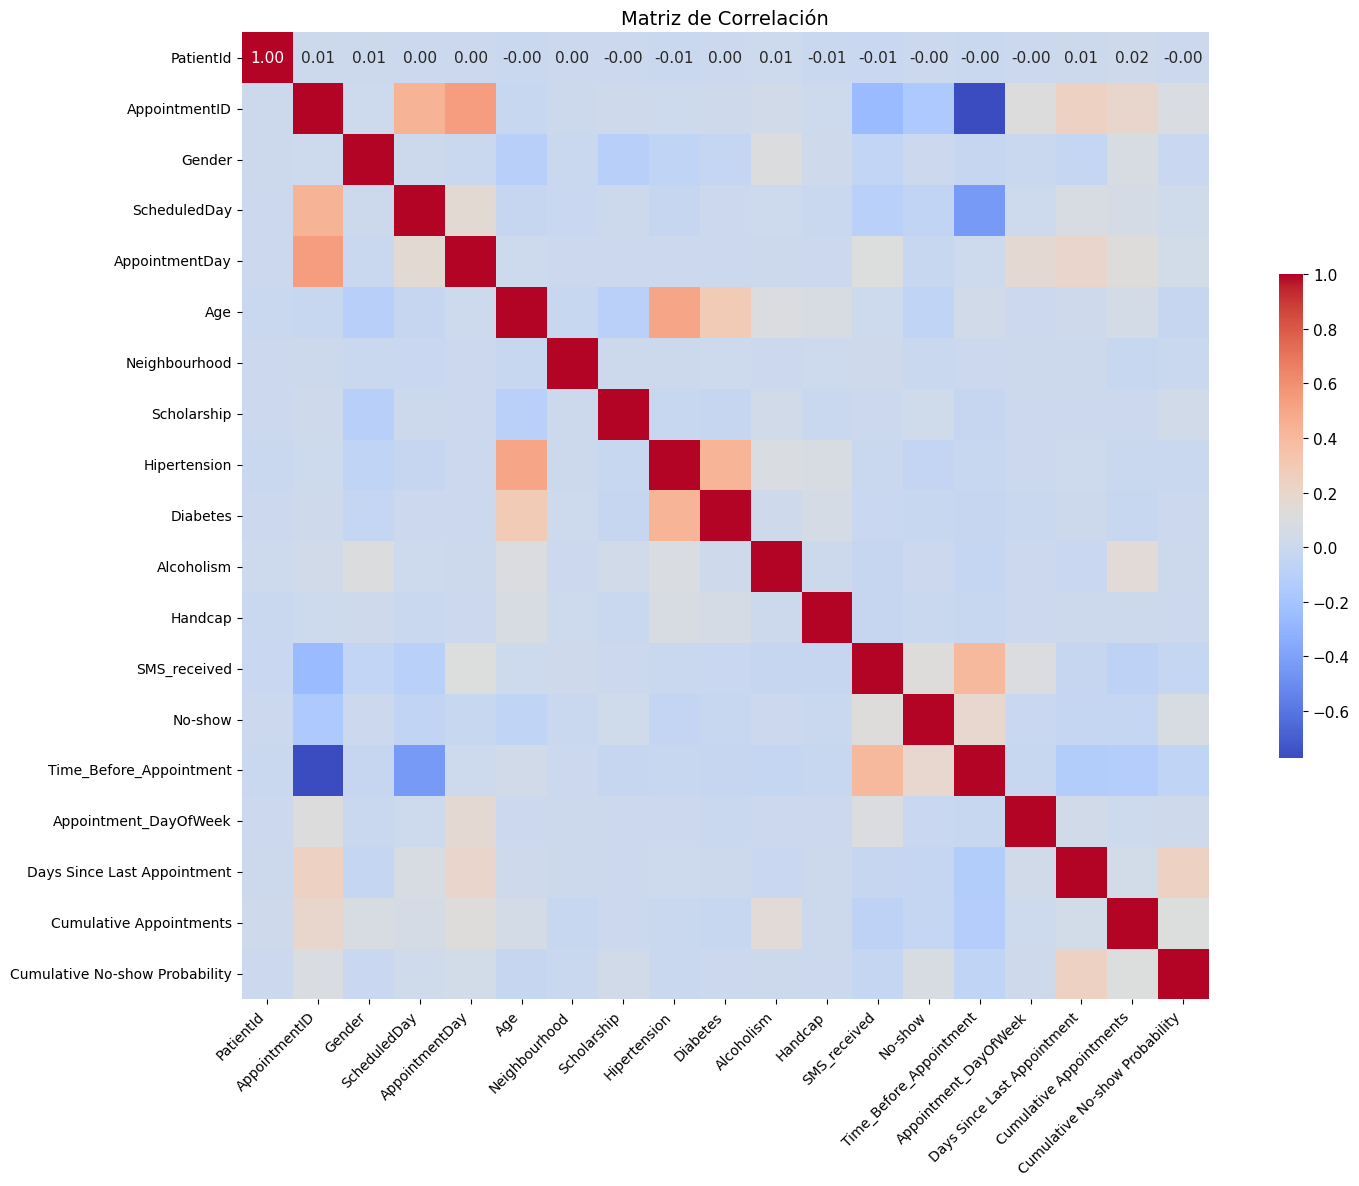

In [39]:
# Se calcula la matriz de correlación
corr = train_df.corr()
plt.figure(figsize=(16, 12))

# Crear el heatmap con números anotados
sns.heatmap(
    corr, 
    annot=True, 
    fmt='.2f', 
    cmap='coolwarm', 
    square=True, 
    cbar_kws={'shrink': .5}, 
    xticklabels=corr.columns, 
    yticklabels=corr.columns
)

plt.xticks(rotation=45, ha='right', size=10)  
plt.yticks(rotation=0, size=10)
plt.title('Matriz de Correlación', size=14)  
plt.tight_layout()
plt.show()



# 3.4) Se cruza la informacion con el dataset de test

In [40]:
# Se verifica que train_df y test_df sean valores del tipo
train_df['PatientId'] = train_df['PatientId'].astype(str)
test_df['PatientId'] = test_df['PatientId'].astype(str)

# Crear el DataFrame temporal, eliminando las filas duplicadas de 'PatientId'
temp_df = train_df[['PatientId', 'Cumulative No-show Probability', 'Cumulative Appointments']].drop_duplicates(subset='PatientId')

# Se realiza la unión de los DataFrames
test_df = test_df.merge(temp_df, on='PatientId', how='left')

# Imputación para los pacientes sin historial en train_df
test_df['Cumulative Appointments'].fillna(0, inplace=True)
test_df['Cumulative No-show Probability'].fillna(train_df['No-show'].mean(), inplace=True)

# Se observan los cambios
test_df.head(10)


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Time_Before_Appointment,Appointment_DayOfWeek,Days Since Last Appointment,Cumulative No-show Probability,Cumulative Appointments
0,758286294715.0,5650654,0,20160503,20160512,66,33,0,1,0,0,0,1,0,748893.0,3,0.0,0.201932,0.0
1,911594989391.0,5692028,0,20160512,20160519,43,75,0,0,0,0,0,0,0,553452.0,3,22.0,0.000000,1.0
2,6685555823843.0,5410963,0,20160301,20160502,74,38,0,0,0,0,0,1,0,5330289.0,1,0.0,0.000000,1.0
3,194877999558458.0,5654977,0,20160503,20160512,68,76,0,0,0,0,0,1,0,721226.0,3,1.0,0.000000,1.0
4,6879299542891.0,5683023,0,20160511,20160511,79,69,0,0,0,0,0,0,0,-25679.0,5,0.0,0.201932,0.0
5,643814388981185.0,5648958,0,20160502,20160516,0,77,0,0,0,0,0,0,0,1147858.0,1,0.0,0.000000,1.0
6,81364641647845.0,5578984,0,20160413,20160504,43,39,0,0,0,0,0,1,0,1763817.0,5,0.0,0.000000,1.0
7,6783416114778.0,5717953,1,20160519,20160519,17,76,0,0,0,0,0,0,0,-31199.0,3,5.0,0.000000,1.0
8,395476288231231.0,5728375,0,20160520,20160531,25,39,0,0,0,0,0,1,0,892178.0,4,38.0,0.000000,1.0
9,232235777468137.0,5542779,1,20160405,20160530,5,38,0,0,0,0,0,1,0,4718332.0,1,0.0,0.201932,0.0


# 3.5) Se elimina la información no relevante

In [41]:
# Se elimina la informacion que no es relevante
train_df = train_df.drop(['PatientId'], axis=1)
test_df = test_df.drop(['PatientId'], axis=1)

# Se verifican dimensiones de los conjuntos de datos
train_df.shape, test_df.shape
print(train_df.shape, test_df.shape)

(88421, 18) (22106, 18)


# 3.6) Se divide el conjunto de entrenamiento en características y etiquetas

In [42]:
# Se divide el conjunto de entrenamiento en características y etiquetas
X_train = train_df.drop('No-show', axis=1)
y_train = train_df['No-show']
X_test = test_df.drop('No-show', axis=1)
y_test = test_df['No-show']

# 4) Se Estandarizan las bases de datos

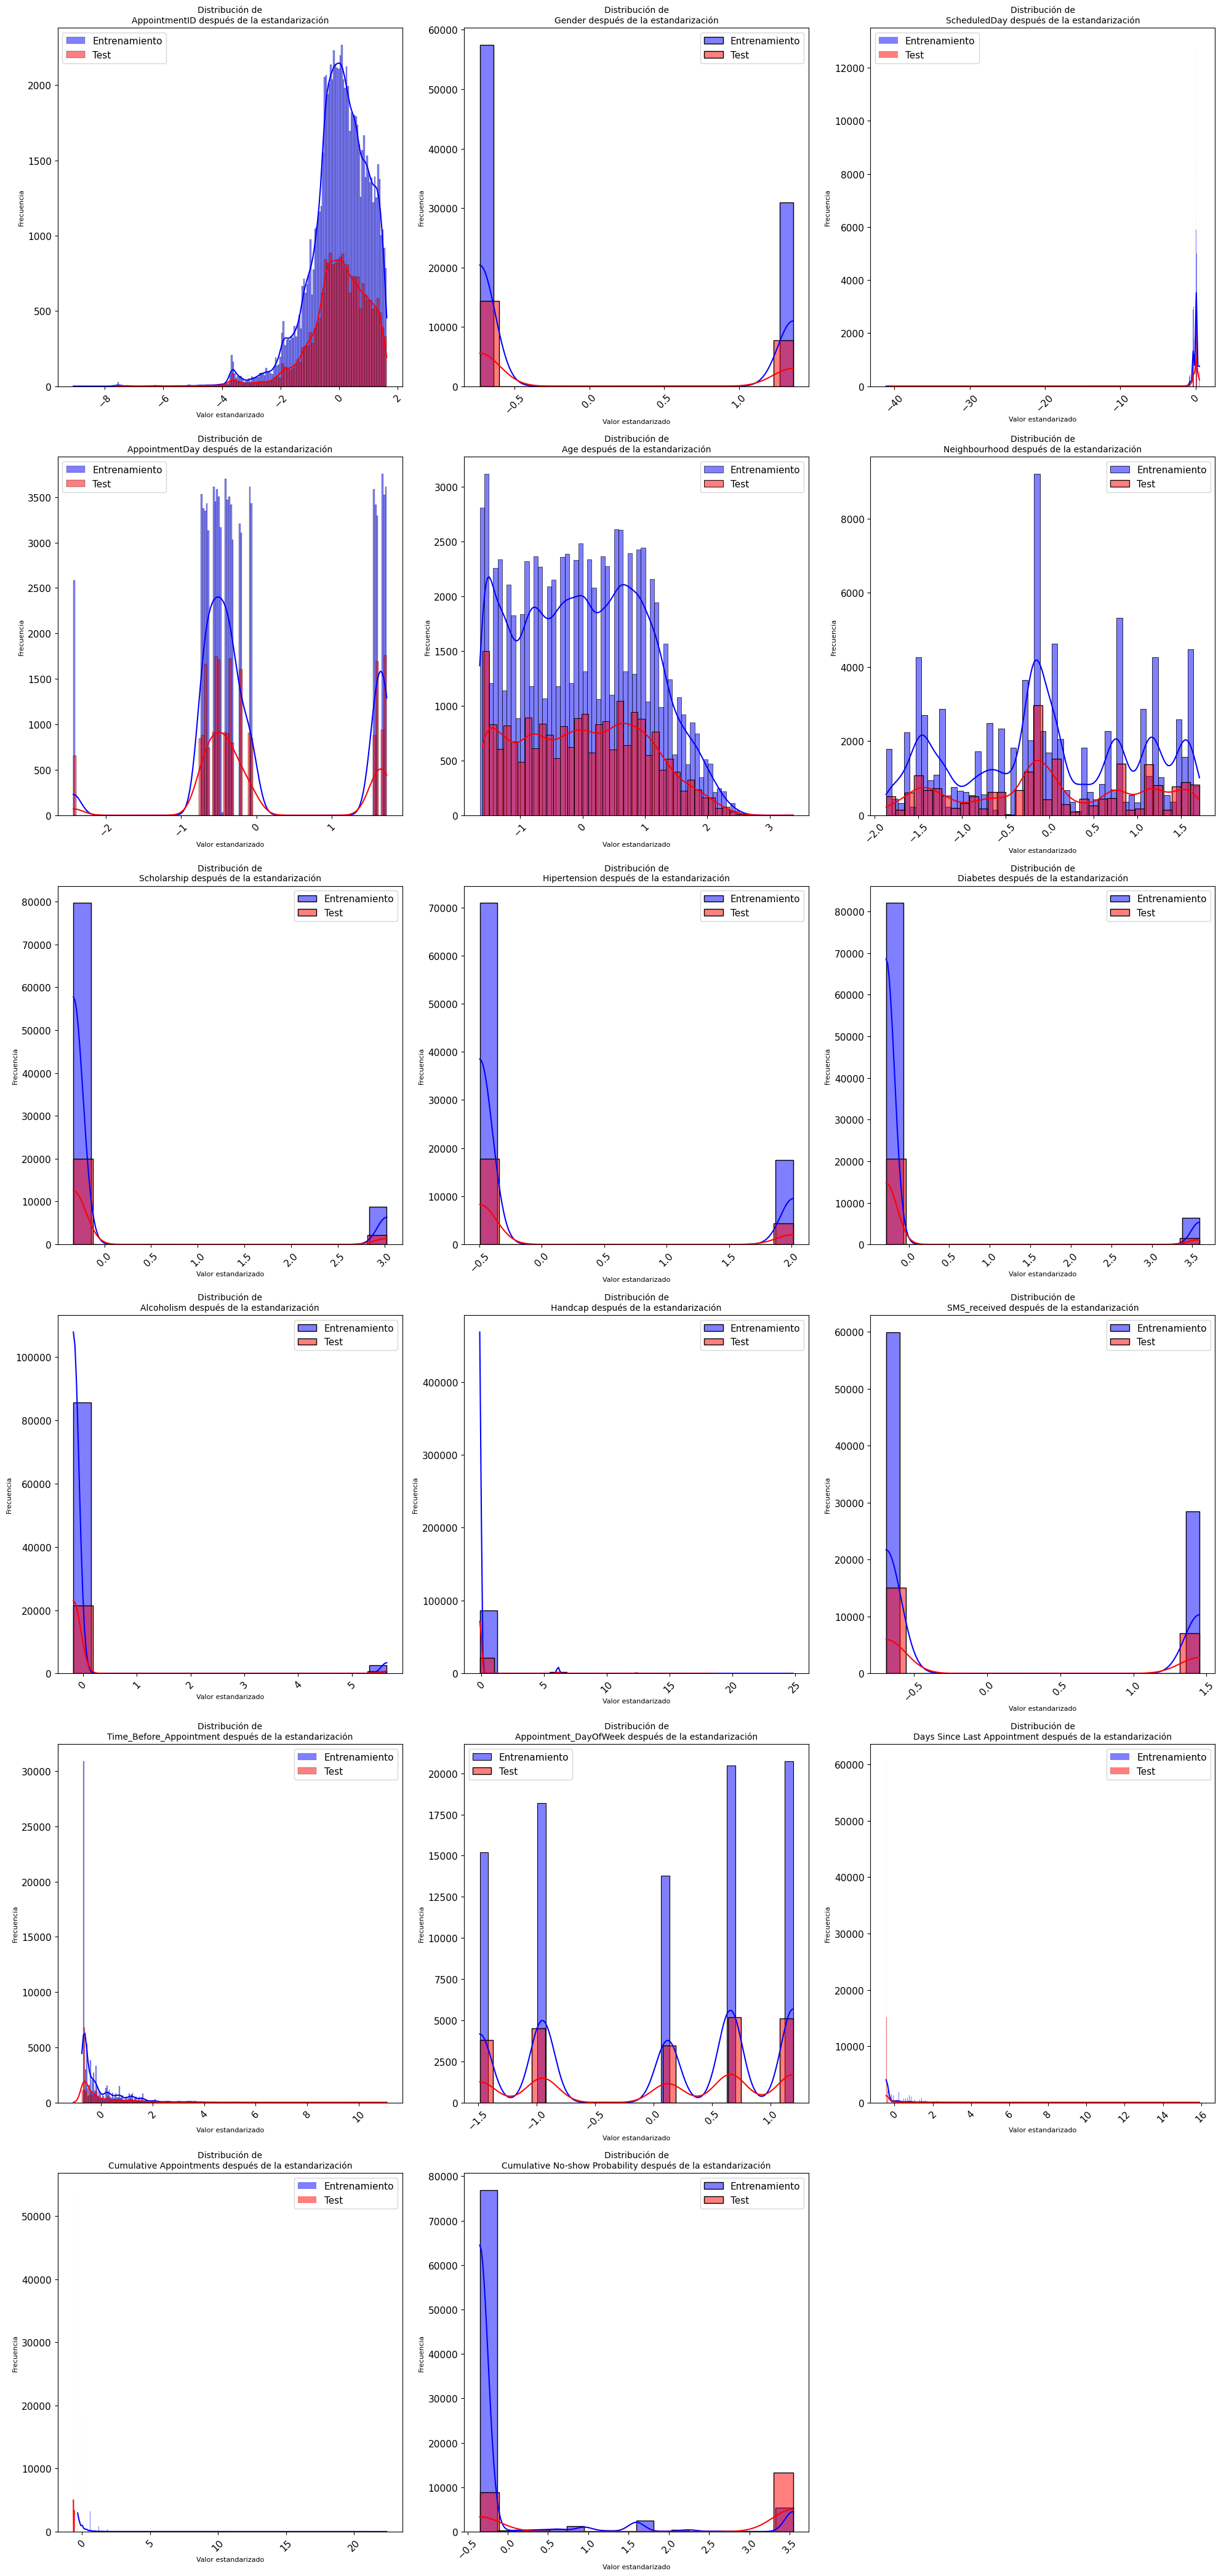

In [43]:
# Guardar los nombres de las columnas
column_names = X_train.columns

# Se crea una instancia de StandardScaler
scaler = StandardScaler()

# Se ajusta el escalador a los datos de entrenamiento y se transforman
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  # Se transforman los datos de test utilizando el mismo escalador que se ajustó a los datos de entrenamiento

# Convertir los resultados a DataFrame para facilitar la manipulación y visualización, utilizando los nombres de las columnas guardados previamente
X_train_df = pd.DataFrame(X_train, columns=column_names)
X_test_df = pd.DataFrame(X_test, columns=column_names)

# Número de características en el DataFrame
num_features = X_train_df.shape[1]

# Número de columnas para los subgráficos
num_columns = 3

# Calcular el número de filas basado en el número de características y columnas
num_rows = num_features // num_columns + (num_features % num_columns > 0)

# Crear una figura grande para acomodar todos los subgráficos
plt.figure(figsize=(20, 7 * num_rows))

# Crear un histograma para cada característica
for i in range(num_features):
    plt.subplot(num_rows, num_columns, i+1)
    
    # Histograma de los datos de entrenamiento en azul
    sns.histplot(X_train_df.iloc[:, i], kde=True, color='blue', alpha=0.5, label='Entrenamiento')
    
    # Histograma de los datos de test en rojo
    sns.histplot(X_test_df.iloc[:, i], kde=True, color='red', alpha=0.5, label='Test')
    
    # Usar un salto de línea para dividir el título en dos líneas
    plt.title(f'Distribución de\n{column_names[i]} después de la estandarización', fontsize=10)
    
    plt.xlabel('Valor estandarizado', fontsize=8)
    plt.ylabel('Frecuencia', fontsize=8)
    plt.xticks(rotation=45)
    plt.legend()

plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()


# 5) Se realiza balanceo de clases en el dataset de entrenamiento

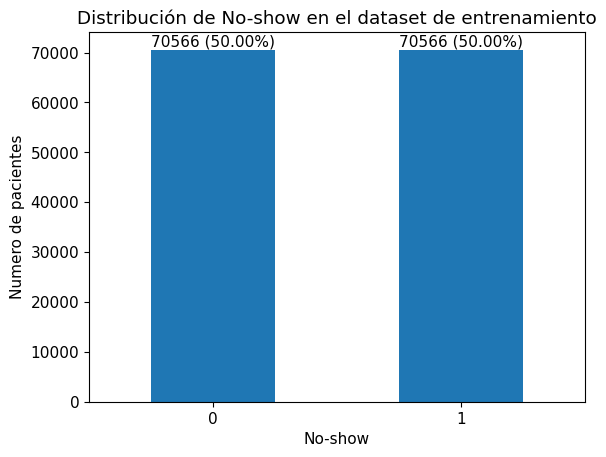

In [44]:
# Se crea una instancia de SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Se aplica SMOTE a los datos
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Se crea una instancia de la clase Pipeline
pipeline = Pipeline([('smote', smote), ('rus', rus)])

# Se aplica el pipeline a los datos
X_train, y_train = pipeline.fit_resample(X_train, y_train)

# Distribución del dataset posterior a la aplicación de SMOTE
class_counts = y_train.value_counts()
class_counts.plot(kind='bar', rot=0)
plt.xlabel('No-show')
plt.ylabel('Numero de pacientes')
plt.title('Distribución de No-show en el dataset de entrenamiento')
for i, count in enumerate(class_counts):
    plt.text(i, count, f'{count} ({count / len(X_train) * 100:.2f}%)', ha='center', va='bottom')
plt.show()

# 6) Reduccion de dimensionalidad 

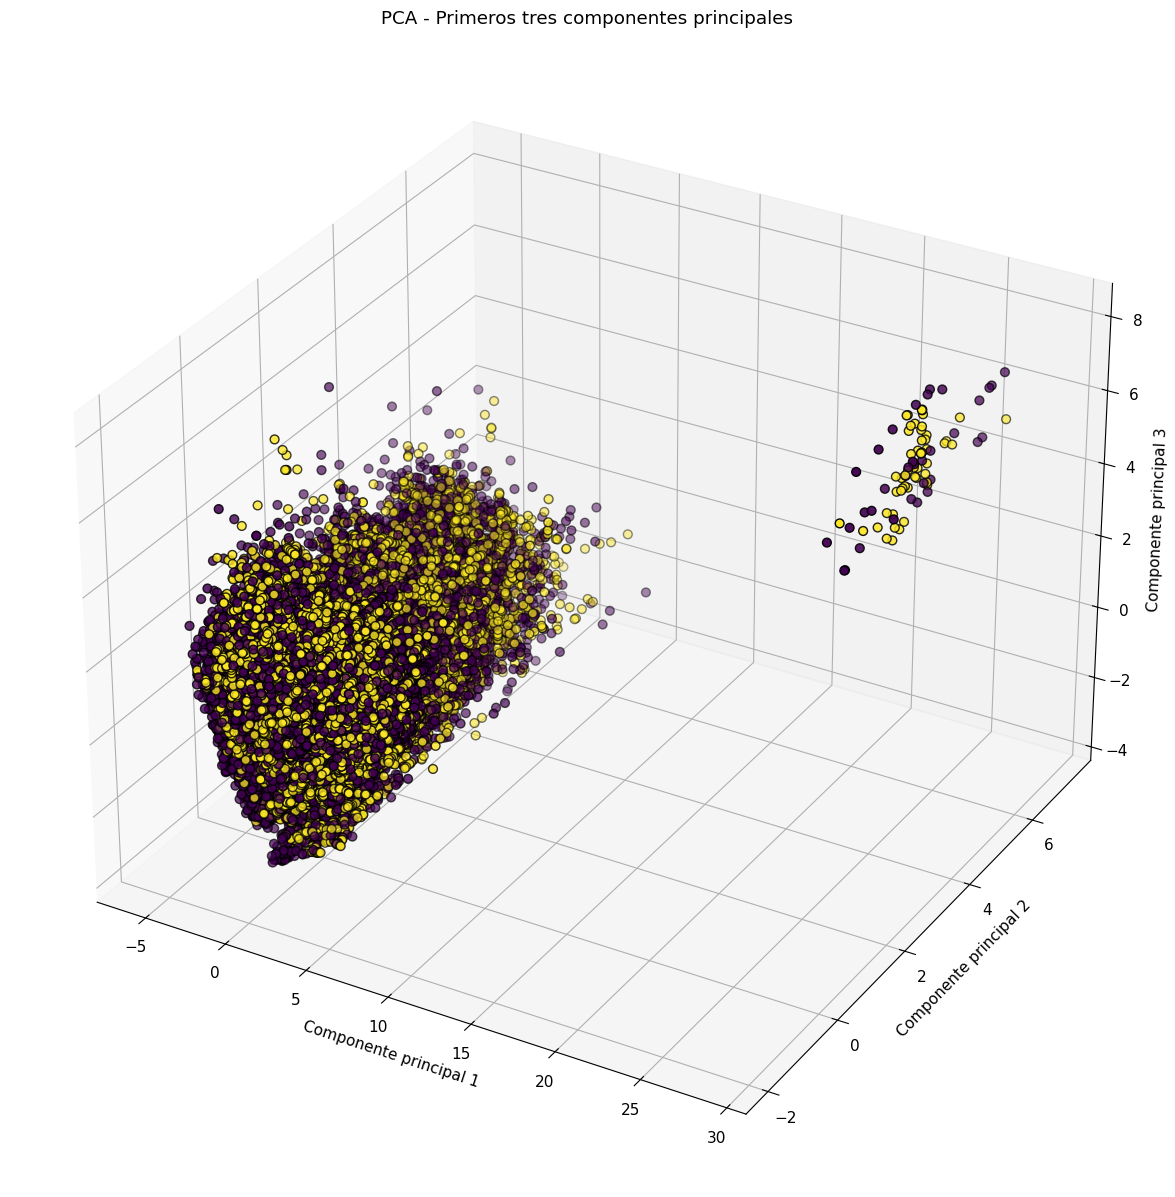

Número de componentes: 15
Varianza explicada por cada componente: [0.15473849 0.10744736 0.08443622 0.07383    0.06877336 0.06370114
 0.05837566 0.05571562 0.0530474  0.05144434 0.04937098 0.04297973
 0.0378701  0.03658018 0.03427974]
Varianza total explicada: 0.9725903089189447


In [45]:
# Aplicar PCA para reducir la dimensionalidad mientras se conserva la mayor cantidad de varianza posible
pca = PCA(n_components=0.95) 

# Ajustar y transformar los datos de entrenamiento
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Graficar los primeros tres componentes principales en un gráfico 3D
fig = plt.figure(figsize=(25, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=y_train, cmap='viridis', edgecolor='k', s=40)
ax.set_title('PCA - Primeros tres componentes principales')
ax.set_xlabel('Componente principal 1')
ax.set_ylabel('Componente principal 2')
ax.set_zlabel('Componente principal 3')
plt.show()

# Imprimir la cantidad de componentes y la varianza explicada
print(f"Número de componentes: {pca.n_components_}")
print(f"Varianza explicada por cada componente: {pca.explained_variance_ratio_}")
print(f"Varianza total explicada: {np.sum(pca.explained_variance_ratio_)}")


In [46]:
#Se guardan los datos de entrenamiento y test en archivos csv
with open('X_train.pkl', 'wb') as file:
    pickle.dump(X_train, file)
# Guardar y_train
with open('y_train.pkl', 'wb') as file:
    pickle.dump(y_train, file)
# Guardar X_test
with open('X_test.pkl', 'wb') as file:
    pickle.dump(X_test, file)
# Guardar y_test
with open('y_test.pkl', 'wb') as file:
    pickle.dump(y_test, file)

# 7) Entrenamiento de modelos de Machine Learning:

In [47]:
# Se cargan los datos de entrenamiento y test desde los archivos csv
with open('X_train.pkl', 'rb') as file:
    X_train = pickle.load(file)
with open('y_train.pkl', 'rb') as file:
    y_train = pickle.load(file)
with open('X_test.pkl', 'rb') as file:
    X_test = pickle.load(file)
with open('y_test.pkl', 'rb') as file:
    y_test = pickle.load(file)


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)



(141132, 15)
(141132,)
(22106, 15)
(22106,)


In [48]:
#Se verifica la base de datos con las que se entrenará el modelo
X_train.shape, y_train.shape
# Se verifican los valores unicos de la variable objetivo en el dataset de entrenamiento
y_train.value_counts()

No-show
0    70566
1    70566
Name: count, dtype: int64

In [49]:
# Se verifica la base de datos con las que se testeara el modelo
X_test.shape, y_test.shape
# Se verifican los valores unicos de la variable objetivo en el dataset de test
y_test.value_counts()


No-show
0    17642
1     4464
Name: count, dtype: int64

In [50]:
# Se define un peso para las clases segun la distribución de las mismas en el dataset de test
class_counts_test = y_test.value_counts()
peso_clase_mayoritaria = class_counts_test[1] / len(y_test)
peso_clase_minoritaria = class_counts_test[0] / len(y_test)
class_weight = {0: peso_clase_mayoritaria, 1: peso_clase_minoritaria}
print (class_weight)

{0: 0.2019361259386592, 1: 0.7980638740613408}


In [51]:
# Se crea una función para evaluar los modelos de clasificación
def evaluar_modelo(modelo, parametros, X_train, y_train, X_test, y_test):

    labels = ['Asiste', 'No-show']
    # Se obtienen los mejores parámetros y el mejor modelo
    best_params = parametros
    best_model = modelo
    # Puntuaciones/probabilidades de la clase positiva
    y_scores_train = cross_val_predict(best_model, X_train, y_train, cv=5, method='predict_proba')[:, 1]

    # Se calcula la predicción del modelo en el conjunto de entrenamiento con validación cruzada
    y_pred_train = cross_val_predict(best_model, X_train, y_train, cv=5)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    precision_train = precision_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train)
    f1_score_train = f1_score(y_train, y_pred_train)
    
    print(f"Mejores parámetros encontrados: {best_params}")
    print('\033[1m' + '.' * len("Resultados datos de entrenamiento con validación cruzada:") + '\n' + "Resultados datos de entrenamiento con validación cruzada:" + '\033[0m')
    print("Accuracy: (Datos Train)", accuracy_train)
    print("Precision: (Datos Train)", precision_train)
    print("Recall: (Datos Train)", recall_train)
    print("F1 Score: (Datos Train)", f1_score_train)
    # Se  hace print de los datos totales de los datos de entrenamiento
    print("Total de datos de entrenamiento:", len(y_train))
    print("Datos de entrenamiento con etiqueta 0:", len(y_train[y_train == 0]))
    print("Datos de entrenamiento con etiqueta 1:", len(y_train[y_train == 1]))

    # Matriz de confusión y curva ROC (datos de entrenamiento)
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    conf_matrix = confusion_matrix(y_train, y_pred_train)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax[0])
    ax[0].set_title('Matriz de Confusión (Datos de Train)')
    ax[0].set_xlabel('Valores Predichos')
    ax[0].set_ylabel('Valores Reales')
    print (conf_matrix)

    # Curva ROC
    fpr, tpr, thresholds = roc_curve(y_train, y_scores_train)
    roc_auc = auc(fpr, tpr)
    
    ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('Tasa de Falsos Positivos')
    ax[1].set_ylabel('Tasa de Verdaderos Positivos')
    ax[1].set_title('Curva ROC (Datos de Train)')
    ax[1].legend(loc="lower right")

    plt.tight_layout()
    plt.show()

    # Hacer predicciones con el mejor modelo en el conjunto de test
    y_pred_test = best_model.predict(X_test)
    # Puntuaciones/probabilidades de la clase positiva
    y_scores_test = modelo.predict_proba(X_test)[:, 1]

    # Calcular y presentar las métricas de evaluación para los datos de test
    accuracy_test = accuracy_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test)
    f1_score_test = f1_score(y_test, y_pred_test)

    print('\033[1m' + '.' * len("Resultados datos de test con el mejor modelo:") + '\n' + "Resultados datos de test con el mejor modelo:" + '\033[0m')
    print(f"Accuracy (Datos de Test): {accuracy_test}") 
    print(f"Precision (Datos de Test): {precision_test}")
    print(f"Recall (Datos de Test): {recall_test}")
    print(f"F1 Score (Datos de Test): {f1_score_test:}")
    # Se  hace print de los datos totales de los datos de test
    print("Total de datos de test:", len(y_test))
    print("Datos de test con etiqueta 0:", len(y_test[y_test == 0]))
    print("Datos de test con etiqueta 1:", len(y_test[y_test == 1]))

    # Matriz de confusión y curva ROC (datos de test)
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels, ax=ax[0])
    ax[0].set_title('Matriz de Confusión (Datos de Test)')
    ax[0].set_xlabel('Valores Predichos')
    ax[0].set_ylabel('Valores Reales')
    print (conf_matrix)

    # Curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_scores_test)
    roc_auc = auc(fpr, tpr)
    
    ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('Tasa de Falsos Positivos')
    ax[1].set_ylabel('Tasa de Verdaderos Positivos')
    ax[1].set_title('Curva ROC (Datos de Test)')
    ax[1].legend(loc="lower right")

    plt.tight_layout()
    plt.show()

7.1 Entrenamiento Regresión Logisitica

Modelo cargado desde el archivo.
Mejores parámetros encontrados: {'C': 1e-11, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
.........................................................
Resultados datos de entrenamiento con validación cruzada:
Accuracy: (Datos Train) 0.5564932120284556
Precision: (Datos Train) 0.5317060755728409
Recall: (Datos Train) 0.9473825921832044
F1 Score: (Datos Train) 0.6811343919225263
Total de datos de entrenamiento: 141132
Datos de entrenamiento con etiqueta 0: 70566
Datos de entrenamiento con etiqueta 1: 70566
[[11686 58880]
 [ 3713 66853]]


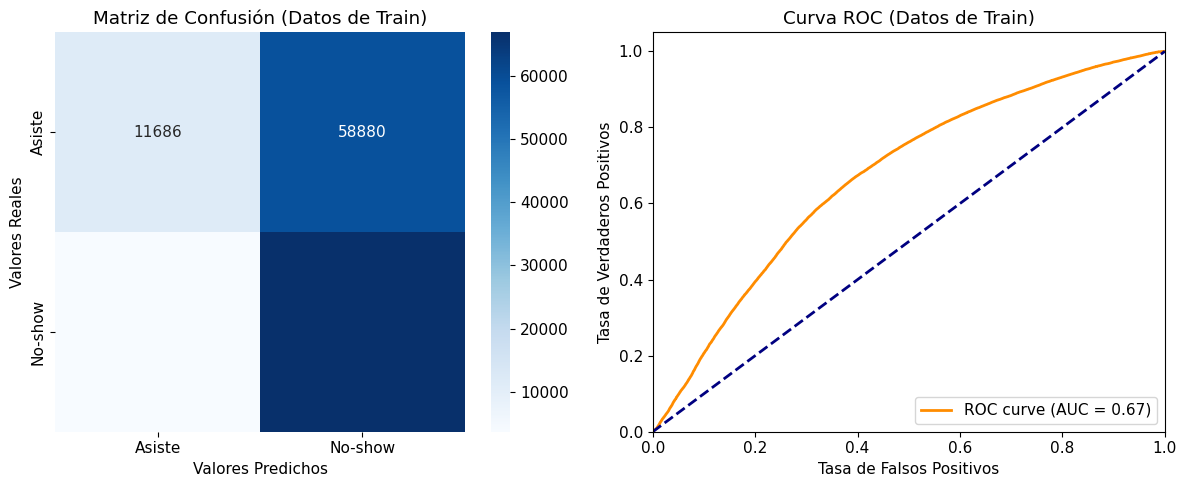

.............................................
Resultados datos de test con el mejor modelo:
Accuracy (Datos de Test): 0.24640369130552792
Precision (Datos de Test): 0.20888040105037
Recall (Datos de Test): 0.9800627240143369
F1 Score (Datos de Test): 0.34436616946751153
Total de datos de test: 22106
Datos de test con etiqueta 0: 17642
Datos de test con etiqueta 1: 4464
[[ 1072 16570]
 [   89  4375]]


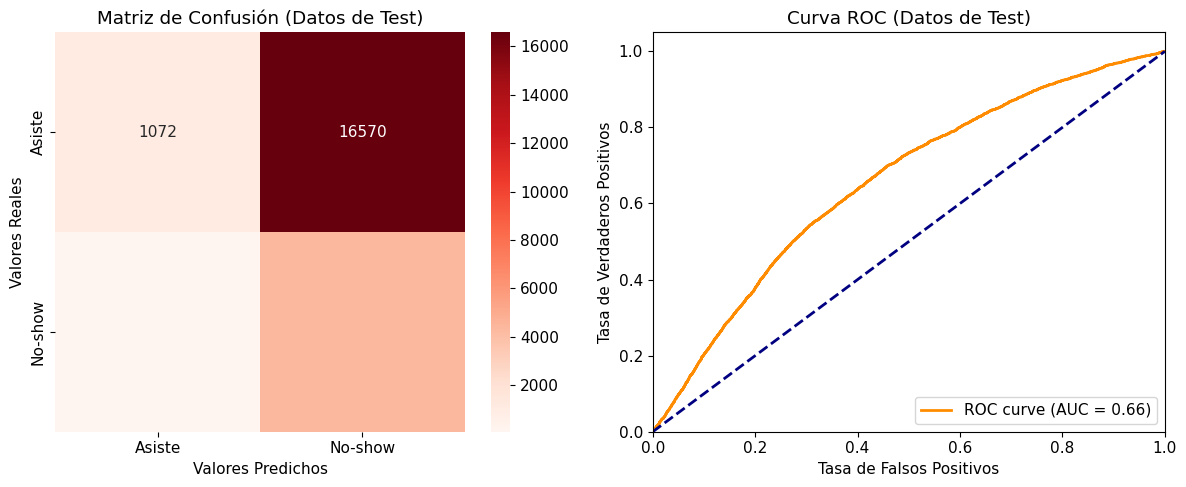

In [52]:
# Nombre del archivo donde se guardará/cargará el modelo
nombre_modelo = 'best_logistic_regression.joblib'
nombre_params = 'best_params_logistic_regression.json'

if os.path.exists(nombre_modelo) and os.path.exists(nombre_params):
    best_model_logistic_regresion = joblib.load(nombre_modelo)
    with open(nombre_params, 'r') as file:
        best_params_logistic_regresion = json.load(file)
    print("Modelo cargado desde el archivo.")
else:
    # Diccionario de parámetros a probar extendiendo el espacio de búsqueda
    param_grid = {
        'max_iter': [1000, 2000, 3000, 4000, 5000],
        'C': [0.1e-10, 0.1e-09, 0.1e-08, 0.1e-07, 0.1e-06, 0.1e-05, 0.1e-04, 0.1e-03, 0.01, 0.1, 1, 10, 100, 1000], # C controla la regularización, sirve para evitar el sobreajuste, a menor C, mayor regularización lo que implica un modelo más simple, con mayor C, el modelo se ajusta más a los datos de entrenamiento
        'penalty': ['l2'],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }

    # Crear una instancia de GridSearchCV optimizada para la precisión
    grid_search = GridSearchCV(LogisticRegression(class_weight=class_weight), param_grid, cv=5, scoring='precision', n_jobs=-1) 

    # Ajustar GridSearchCV
    grid_search.fit(X_train, y_train)

    # Guardar el mejor modelo
    best_model_logistic_regresion = grid_search.best_estimator_

    # Guardar el modelo en el archivo
    joblib.dump(best_model_logistic_regresion, nombre_modelo)
    print("Modelo entrenado y guardado en el archivo.")
    # Guardar los mejores parámetros en un archivo JSON
    best_params_logistic_regresion = grid_search.best_params_
    with open(nombre_params, 'w') as file:
        json.dump(best_params_logistic_regresion, file)

# Evaluar el modelo (tanto si se acaba de entrenar como si se ha cargado desde un archivo)
evaluar_modelo(best_model_logistic_regresion, best_params_logistic_regresion, X_train, y_train, X_test, y_test)


7.2 Entrenamiento de DecisionTreeClassifier

Modelo cargado desde el archivo.
Mejores parámetros encontrados: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2}
.........................................................
Resultados datos de entrenamiento con validación cruzada:
Accuracy: (Datos Train) 0.7471516027548678
Precision: (Datos Train) 0.7409674344059577
Recall: (Datos Train) 0.7599835614885355
F1 Score: (Datos Train) 0.7503550366229896
Total de datos de entrenamiento: 141132
Datos de entrenamiento con etiqueta 0: 70566
Datos de entrenamiento con etiqueta 1: 70566
[[51818 18748]
 [16937 53629]]


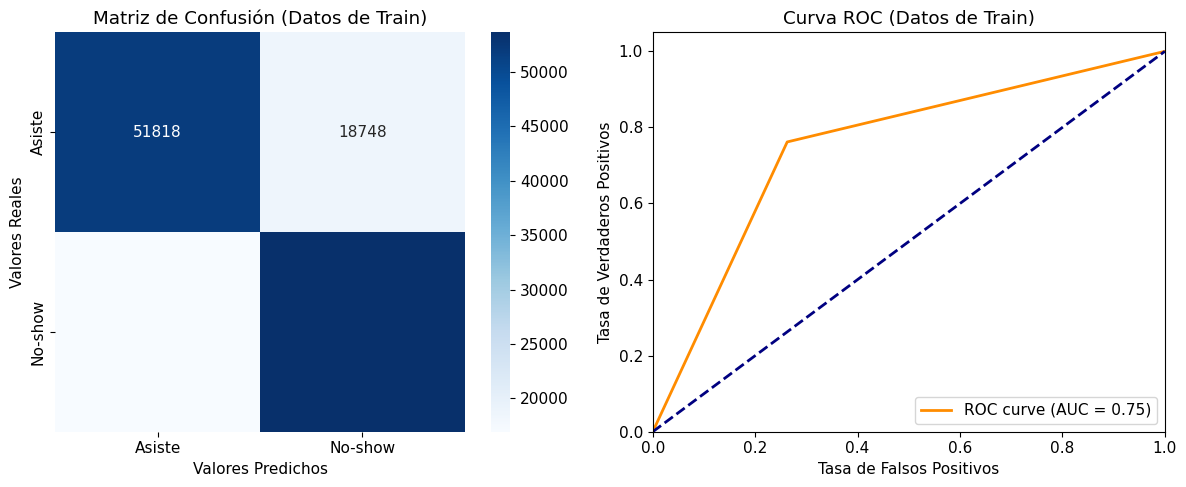

.............................................
Resultados datos de test con el mejor modelo:
Accuracy (Datos de Test): 0.6663349316927532
Precision (Datos de Test): 0.2528852681602172
Recall (Datos de Test): 0.33378136200716846
F1 Score (Datos de Test): 0.28775589030513704
Total de datos de test: 22106
Datos de test con etiqueta 0: 17642
Datos de test con etiqueta 1: 4464
[[13240  4402]
 [ 2974  1490]]


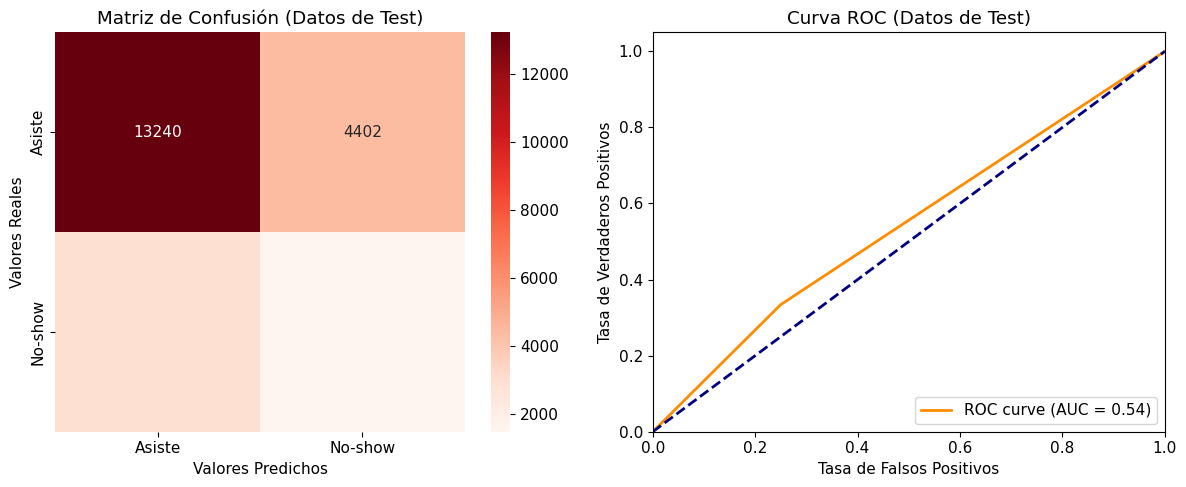

In [53]:
# Nombre del archivo donde se guardará/cargará el modelo
nombre_modelo = 'best_model_tree.joblib'
nombre_params = 'best_params_tree.json'

if os.path.exists(nombre_modelo) and os.path.exists(nombre_params):
    best_model_tree = joblib.load(nombre_modelo)
    with open(nombre_params, 'r') as file:
        best_params_tree = json.load(file)
        grid_search = best_params_tree
    print("Modelo cargado desde el archivo.")
else:
    # Diccionario de parámetros a probar extendiendo el espacio de búsqueda
    param_grid = {
    'max_depth': [None, 5, 10, 15, 20],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10, 15],  # Número de muestras para dividir
    'min_samples_leaf': [1, 2, 5, 10],  # Múmero de muestras en un nodo hoja
    'criterion': ['gini', 'entropy'],  # Función para medir el grado de impureza
    'max_features': ['auto', 'sqrt', 'log2', None],  # Número de características
    'max_leaf_nodes': [None, 10, 20, 30, 40],  # Número máximo de nodos hoja
    'min_impurity_decrease': [0.0, 0.01, 0.02]  # Umbral para la reducción de la impureza
}

   # Crear una instancia de GridSearchCV, optimizada para la precisión
    grid_search = GridSearchCV(DecisionTreeClassifier(class_weight=class_weight), param_grid, cv=5, scoring='precision', n_jobs=-1)

   # Ajustar GridSearchCV a los datos
    grid_search.fit(X_train, y_train)

    # Guardar el mejor modelo
    best_model_tree = grid_search.best_estimator_

    # Guardar el modelo en el archivo
    joblib.dump(best_model_tree, nombre_modelo)
    print("Modelo entrenado y guardado en el archivo.")
    # Guardar los mejores parámetros en un archivo JSON
    best_params_tree = grid_search.best_params_
    with open(nombre_params, 'w') as f:
        json.dump(best_params_tree, f)

# Evaluar el modelo (tanto si se acaba de entrenar como si se ha cargado desde un archivo)
evaluar_modelo (best_model_tree, grid_search, X_train, y_train, X_test, y_test)

7.3 Entrenamiento de Support Vector Machine

Modelo cargado desde el archivo.
Mejores parámetros encontrados: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf', 'probability': True}
.........................................................
Resultados datos de entrenamiento con validación cruzada:
Accuracy: (Datos Train) 0.5696581923305841
Precision: (Datos Train) 0.5379502026635785
Recall: (Datos Train) 0.9874160360513562
F1 Score: (Datos Train) 0.6964631092852753
Total de datos de entrenamiento: 141132
Datos de entrenamiento con etiqueta 0: 70566
Datos de entrenamiento con etiqueta 1: 70566
[[10719 59847]
 [  888 69678]]


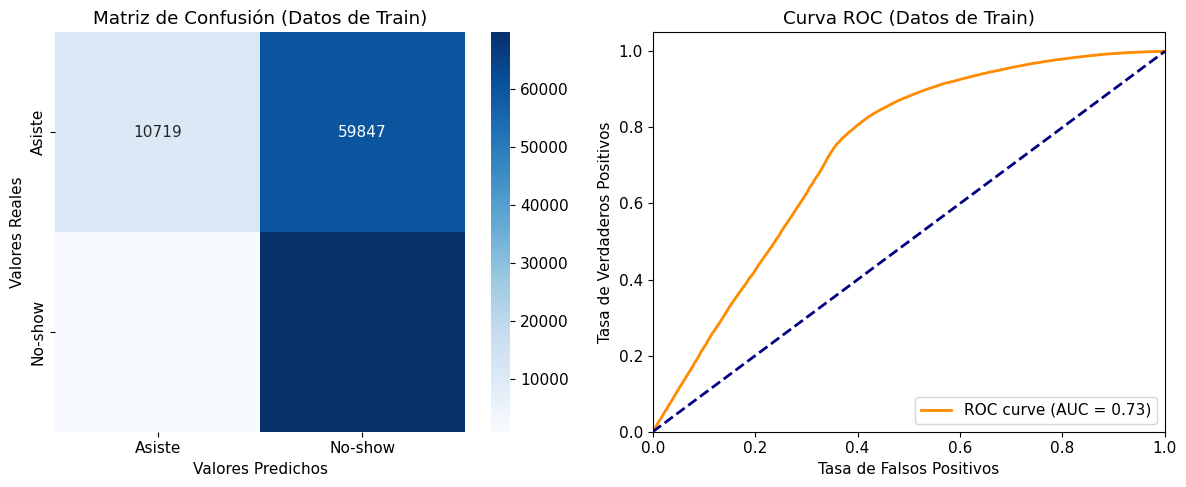

.............................................
Resultados datos de test con el mejor modelo:
Accuracy (Datos de Test): 0.3337555414819506
Precision (Datos de Test): 0.22286424019872556
Recall (Datos de Test): 0.9245071684587813
F1 Score (Datos de Test): 0.35915063963101557
Total de datos de test: 22106
Datos de test con etiqueta 0: 17642
Datos de test con etiqueta 1: 4464
[[ 3251 14391]
 [  337  4127]]


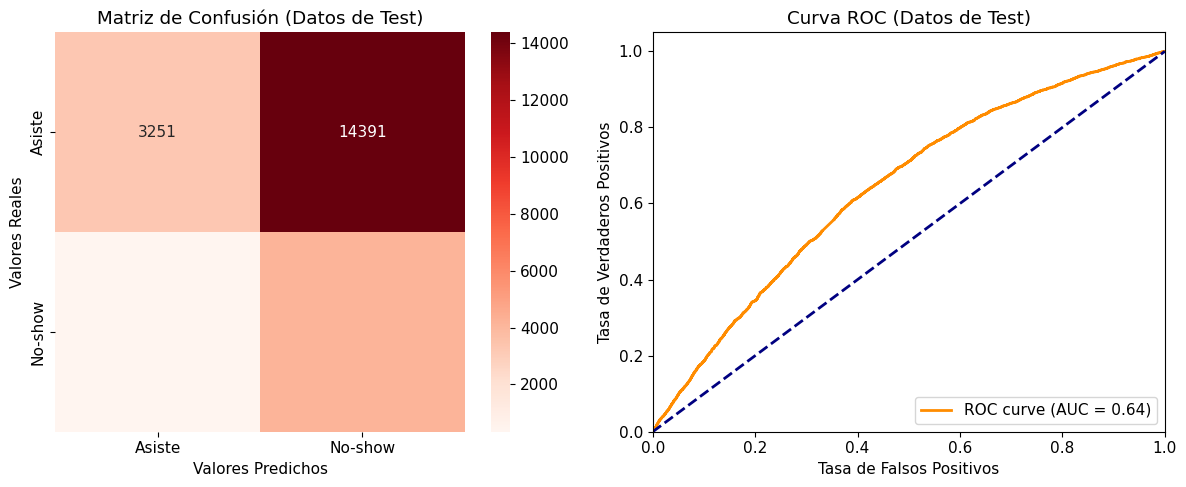

In [54]:
# Nombre del archivo donde se guardará/cargará el modelo
nombre_modelo = 'best_model_svm.joblib'
nombre_params = 'best_params_svm.json'

if os.path.exists(nombre_modelo) and os.path.exists(nombre_params):
    best_model_svm = joblib.load(nombre_modelo)
    with open(nombre_params, 'r') as file:
        best_params_svm = json.load(file)
    print("Modelo cargado desde el archivo.")
else:
    # Diccionario de parámetros a probar
    param_grid = {
        'C': [0.1, 1, 10],  # Parámetro de regularización, controla el sobreajuste
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Tipo de kernel, permite separaciones no lineales
        'gamma': ['scale', 'auto'],  # Coeficiente de kernel para 'rbf', 'poly' y 'sigmoid', controla el sobreajuste
        'probability': [True]  # Permite el cálculo de probabilidades
    }

 #"Mejores parámetros encontrados: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}\n",

    # Crear una instancia de GridSearchCV optimizada para la precisión
    grid_search = GridSearchCV(SVC(class_weight=class_weight), param_grid, cv=5, scoring='precision', verbose=10, n_jobs=-1)

    # Ajustar GridSearchCV
    grid_search.fit(X_train, y_train)

    # Guardar el mejor modelo
    best_model_svm = grid_search.best_estimator_

    # Guardar el modelo en el archivo
    joblib.dump(best_model_svm, nombre_modelo)
    # Guardar los mejores parámetros en el archivo
    best_params_svm = grid_search.best_params_
    with open(nombre_params, 'w') as file:
        json.dump(grid_search.best_params_, file)
    print("Modelo entrenado y guardado en el archivo.")

# Evaluar el modelo (tanto si se acaba de entrenar como si se ha cargado desde un archivo)
evaluar_modelo (best_model_svm, best_params_svm, X_train, y_train, X_test, y_test)



7.4 Entrranamiento de red neuronal

Epoch [1/100], Loss: 0.6922
Epoch [2/100], Loss: 0.6984
Epoch [3/100], Loss: 0.6818
Epoch [4/100], Loss: 0.7080
Epoch [5/100], Loss: 0.6958
Epoch [6/100], Loss: 0.6990
Epoch [7/100], Loss: 0.6915
Epoch [8/100], Loss: 0.6947
Epoch [9/100], Loss: 0.6922
Epoch [10/100], Loss: 0.7000
Epoch [11/100], Loss: 0.6921
Epoch [12/100], Loss: 0.6832
Epoch [13/100], Loss: 0.6788
Epoch [14/100], Loss: 0.6818
Epoch [15/100], Loss: 0.7007
Epoch [16/100], Loss: 0.6869
Epoch [17/100], Loss: 0.6909
Epoch [18/100], Loss: 0.6883
Epoch [19/100], Loss: 0.6863
Epoch [20/100], Loss: 0.6937
Epoch [21/100], Loss: 0.6836
Epoch [22/100], Loss: 0.6889
Epoch [23/100], Loss: 0.6984
Epoch [24/100], Loss: 0.7006
Epoch [25/100], Loss: 0.6845
Epoch [26/100], Loss: 0.6984
Epoch [27/100], Loss: 0.7087
Epoch [28/100], Loss: 0.6933
Epoch [29/100], Loss: 0.6803
Epoch [30/100], Loss: 0.6840
Epoch [31/100], Loss: 0.6870
Epoch [32/100], Loss: 0.7000
Epoch [33/100], Loss: 0.6790
Epoch [34/100], Loss: 0.6641
Epoch [35/100], Loss: 0

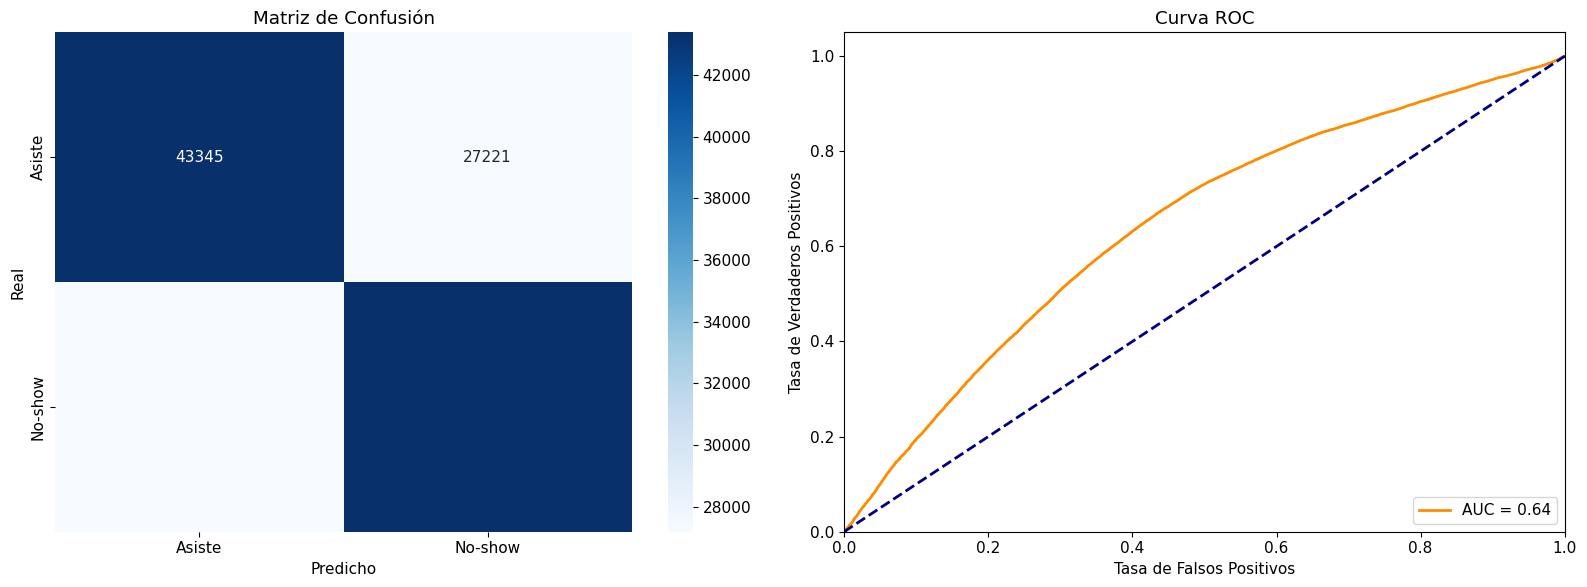

.........................
Resultados datos de test:
Accuracy: 0.5486
Precision: 0.2657
Recall: 0.7003
F1 Score: 0.3852


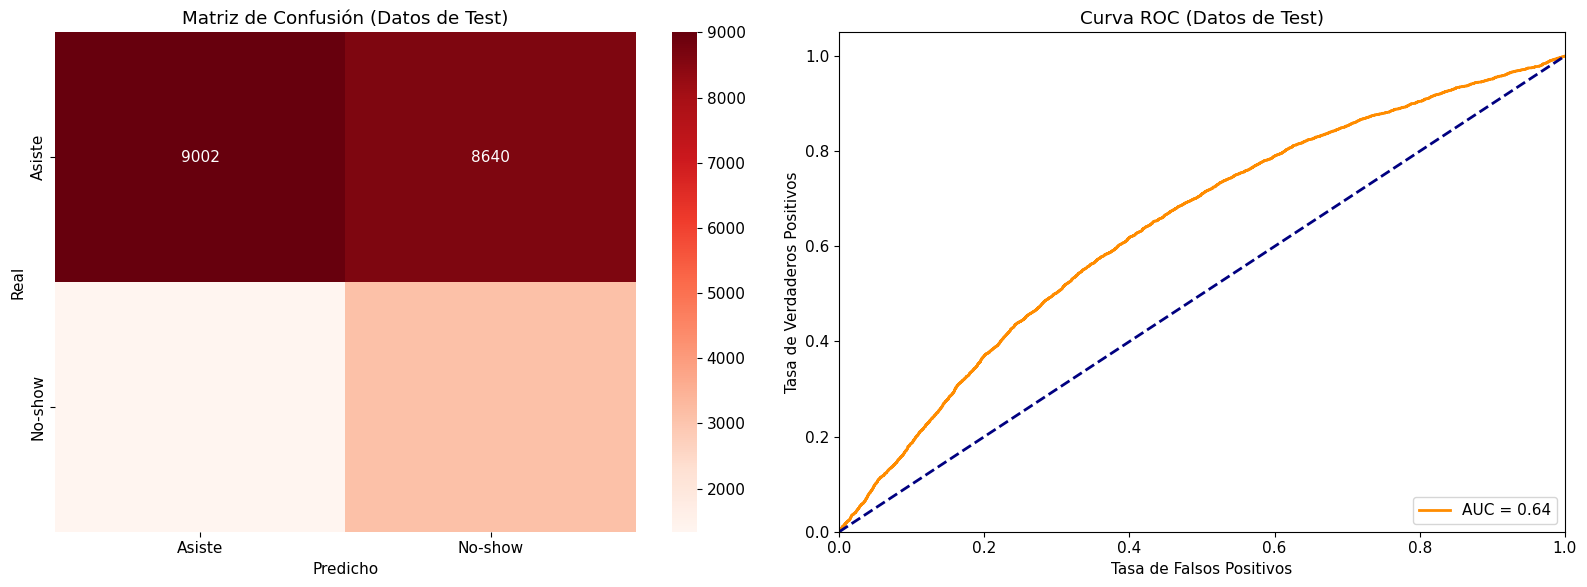

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Se verifica si hay una GPU disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Definir la arquitectura del modelo
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input_size, 15)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(15, 480) # Numero de neuronas en la capa oculta
        self.output_layer = nn.Linear(480, 1) # Numero de neuronas en la capa de salida
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        out = self.relu(out)
        out = self.output_layer(out)
        out = self.sigmoid(out)
        return out

# Convertir datos a tensores de PyTorch
X_train_tensor = torch.tensor(X_train).float().to(device)
y_train_tensor = torch.tensor(y_train.to_numpy()[:, None]).float().to(device)  # Añade una dimensión extra a y_train de forma compatible
X_test_tensor = torch.tensor(X_test).float().to(device)
y_test_tensor = torch.tensor(y_test.to_numpy()[:, None]).float().to(device)

# Crear datasets y dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Inicializar el modelo, el criterio de pérdida y el optimizador
model = NeuralNet(X_train.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7) # Se utiliza el optimizador Adam, lr es la tasa de aprendizaje, a menor lr, más lento es el aprendizaje

# Entrenar el modelo
num_epochs = 100
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
# Se loguea el progreso por epoca
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
          
# Evaluar el modelo
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy()
    y_pred = (y_pred > 0.5).astype(int)

##############################################################################################################
# Se prueba el modelo con el dataset de train
y_pred = model(X_train_tensor).detach().cpu().numpy()
y_pred_bin = (y_pred > 0.5).astype(int)

# Se calculan las mnetricas de evaluacion (Datos de Train)
accuracy = accuracy_score(y_train, y_pred_bin)
precision = precision_score(y_train, y_pred_bin)
recall = recall_score(y_train, y_pred_bin)
f1 = f1_score(y_train, y_pred_bin)


print('\033[1m' + '.' * len("Resultados datos de entrenamiento:") + '\n' + "Resultados datos de entrenamiento:" + '\033[0m')
# Se imprimen las metricas de evaluacion (Datos de Train)
print(f"Accuracy (Datos de Train): {accuracy}")
print(f"Precision (Datos de Train): {precision}")
print(f"Recall (Datos de Train): {recall}")
print(f"F1 Score (Datos de Train): {f1}")

# Configurar la figura para los subgráficos
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Matriz de confusión
conf_matrix = confusion_matrix(y_train, y_pred_bin)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Asiste', 'No-show'], yticklabels=['Asiste', 'No-show'])
axes[0].set_title('Matriz de Confusión')
axes[0].set_xlabel('Predicho')
axes[0].set_ylabel('Real')

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_train, y_pred)
roc_auc = auc(fpr, tpr)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_title('Curva ROC')
axes[1].set_xlabel('Tasa de Falsos Positivos')
axes[1].set_ylabel('Tasa de Verdaderos Positivos')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

##############################################################################################################
# Evaluar el modelo y obtener predicciones (Datos de Test)
y_pred_test = model(X_test_tensor).detach().cpu().numpy()
y_pred_test_bin = (y_pred_test > 0.5).astype(int)

# Calcular métricas de evaluación
accuracy_test = accuracy_score(y_test, y_pred_test_bin)
precision_test = precision_score(y_test, y_pred_test_bin)
recall_test = recall_score(y_test, y_pred_test_bin)
f1_test = f1_score(y_test, y_pred_test_bin)

print('\033[1m' + '.' * len("Resultados datos de test:") + '\n' + "Resultados datos de test:" + '\033[0m')
# Imprimir las métricas de evaluación
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1 Score: {f1_test:.4f}")

# Configurar la figura para los subgráficos
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Matriz de confusión
conf_matrix_test = confusion_matrix(y_test, y_pred_test_bin)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Reds', ax=axes[0],
            xticklabels=['Asiste', 'No-show'], yticklabels=['Asiste', 'No-show'])
axes[0].set_title('Matriz de Confusión (Datos de Test)')
axes[0].set_xlabel('Predicho')
axes[0].set_ylabel('Real')

# Curva ROC
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test)
roc_auc_test = auc(fpr_test, tpr_test)
axes[1].plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'AUC = {roc_auc_test:.2f}')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_title('Curva ROC (Datos de Test)')
axes[1].set_xlabel('Tasa de Falsos Positivos')
axes[1].set_ylabel('Tasa de Verdaderos Positivos')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()